In [51]:
from pathlib import Path 
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [56]:
to_2013_data_dir = Path(r"C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\2013_returns")
to_2023_data_dir = Path(r"C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns")

In [57]:
def read_data(dir: Path) -> dict[str, pl.DataFrame]:
    data_dict = {}

    for company in dir.iterdir():
        company_name = company.name.split(".")[0]
        df = pl.read_parquet(company)
        data_dict[company_name] = df
        
    return data_dict

In [58]:
to_23_dict = read_data(to_2023_data_dir)
to_13_dict = read_data(to_2013_data_dir)

In [38]:
def assess_cross_sec_dist(data: dict[str, pl.DataFrame], score: str) -> None:
    for time_period in range(20):
        cross_sec_values = []
        
        for company in data:
            df = data[company]

            if time_period < len(df.columns) - 1:
                value = df.filter(pl.col("row_names") == score).select(pl.col(df.columns[time_period])).item()
                cross_sec_values.append(value)


        # KDE plot
        plt.figure(figsize=(8, 5))
        sns.kdeplot(cross_sec_values, bw_adjust=0.5, label="Empirical PDF (KDE)", fill=True)
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.title("Empirical Probability Density Function (KDE)")
        plt.legend()
        plt.grid()
        plt.show()

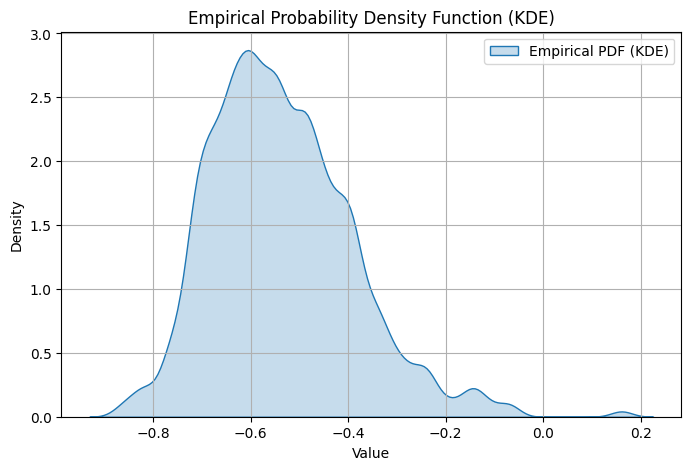

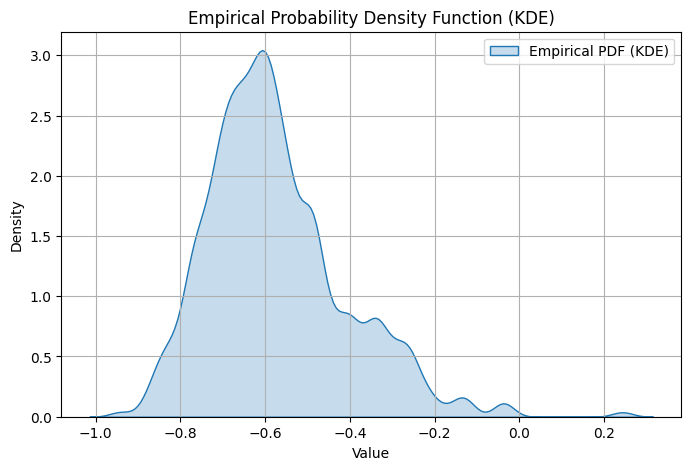

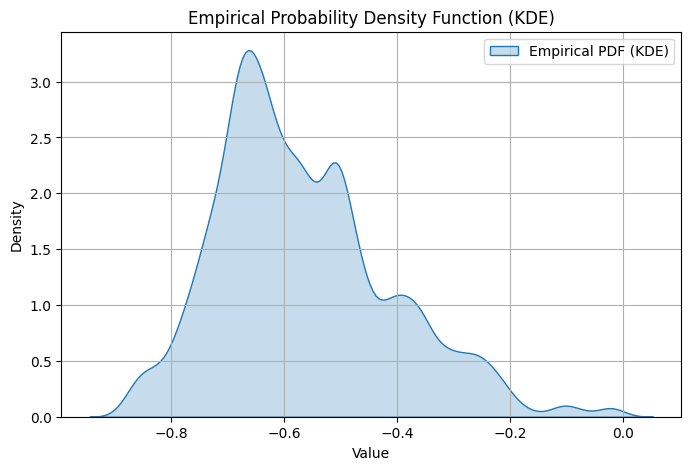

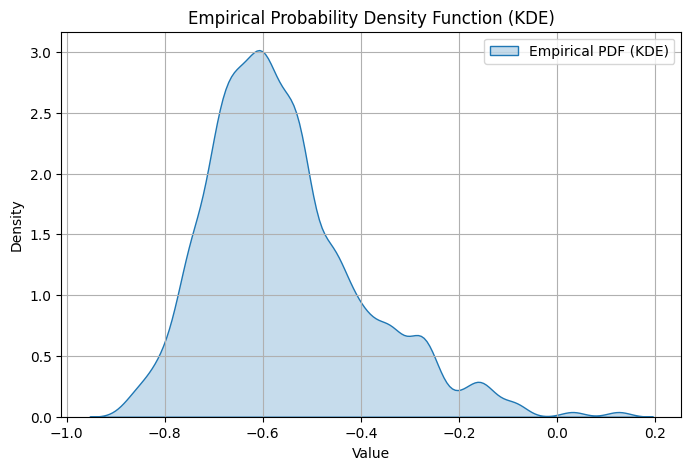

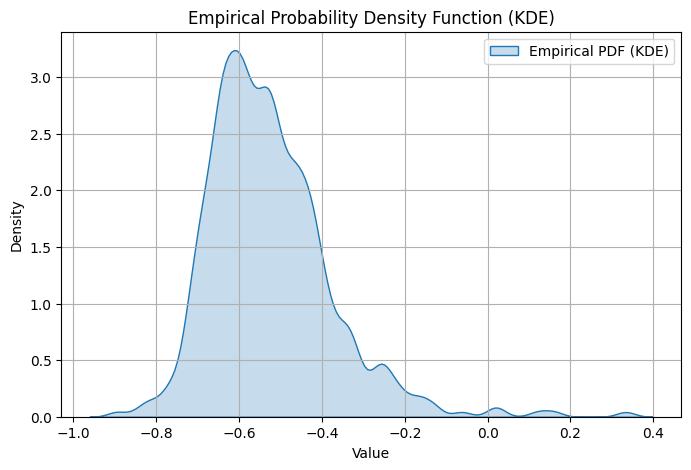

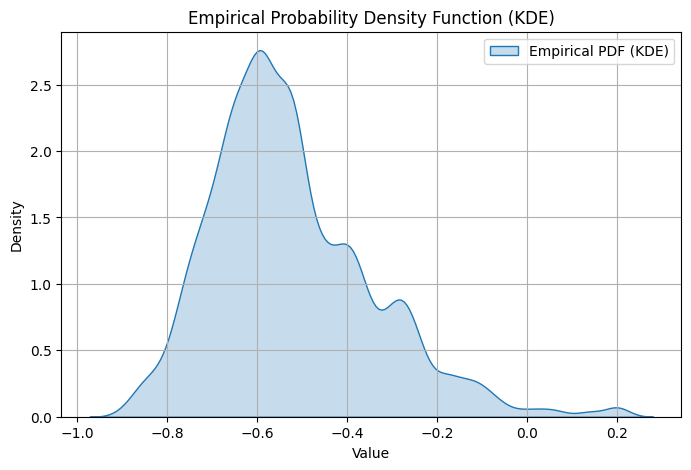

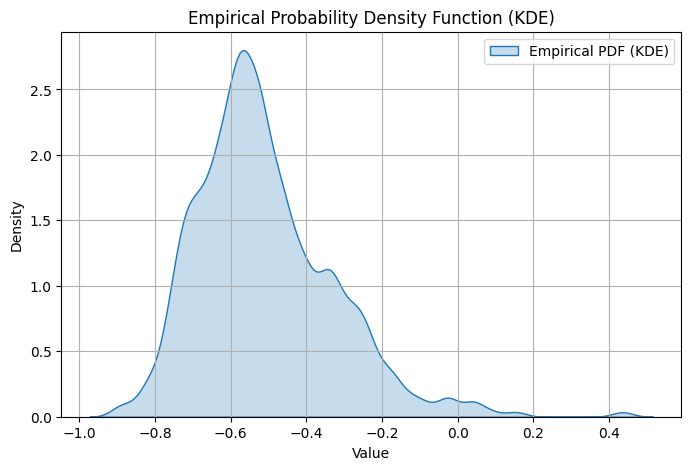

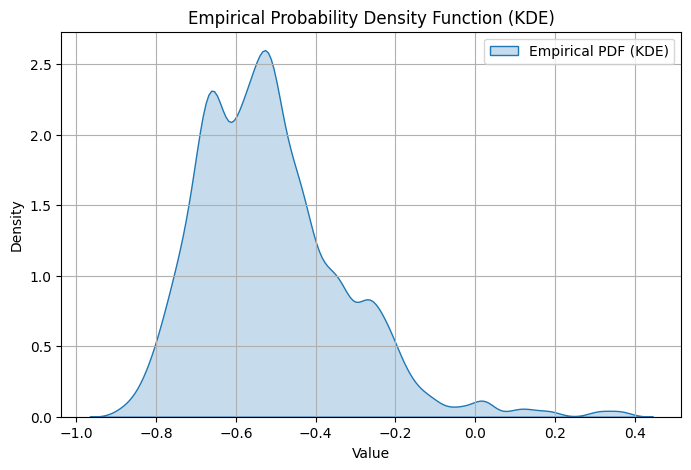

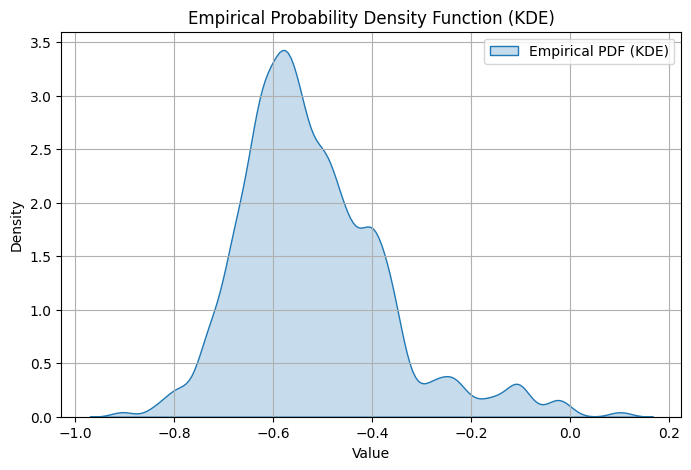

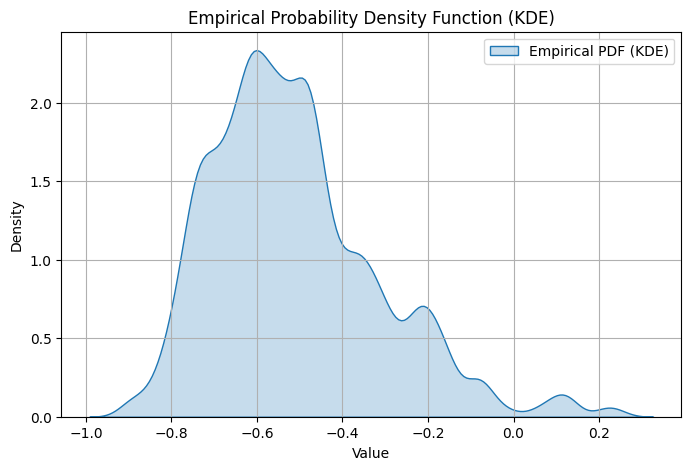

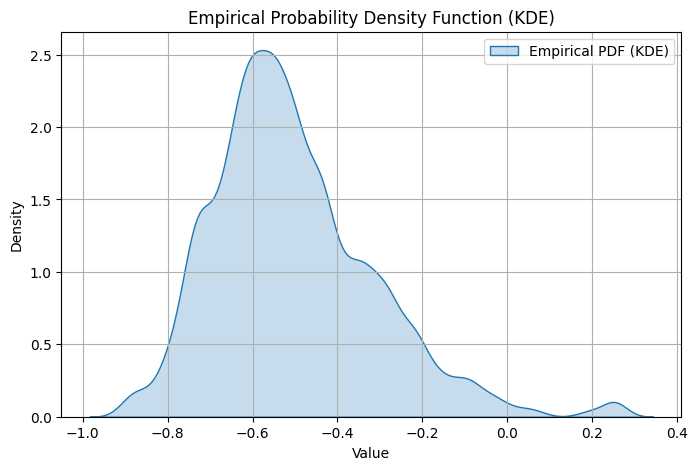

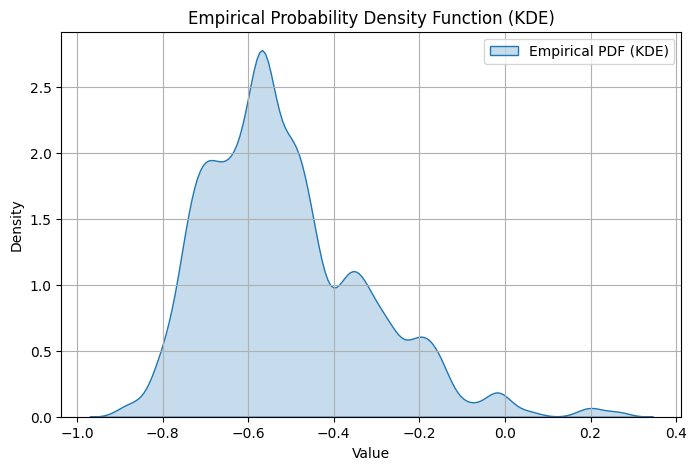

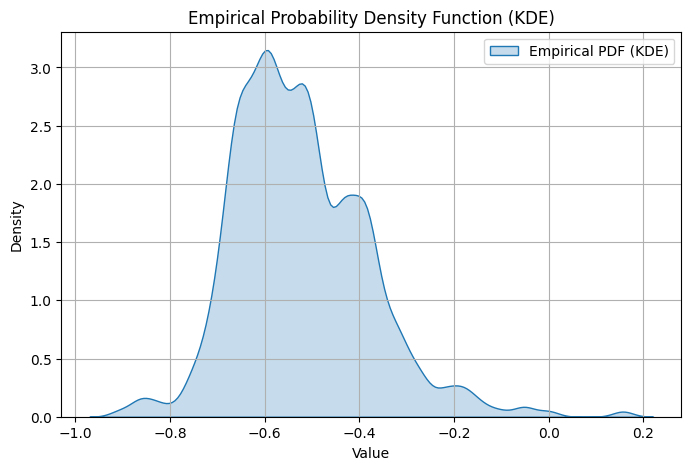

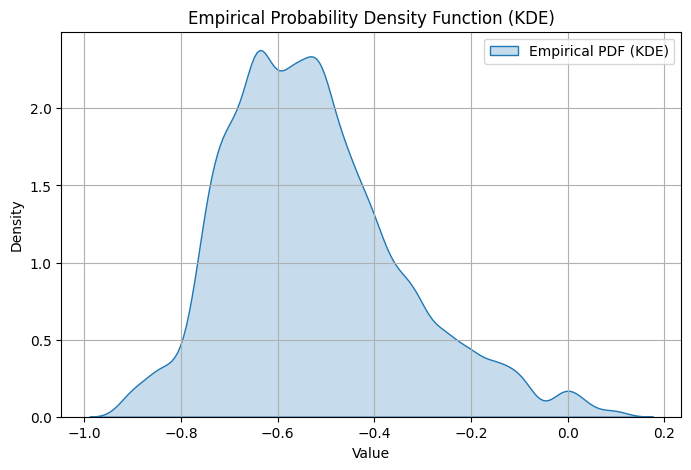

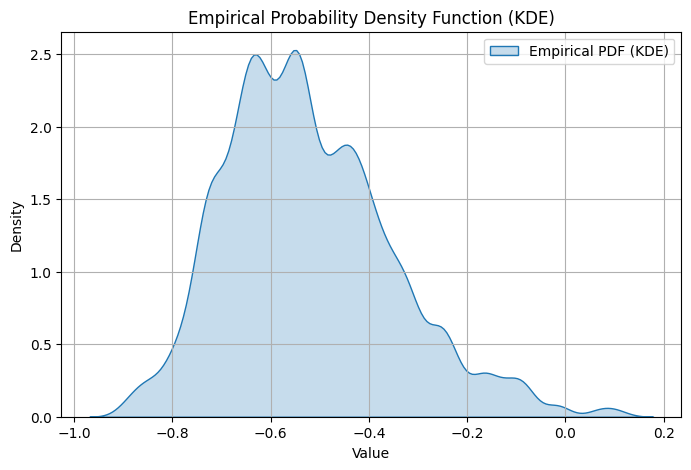

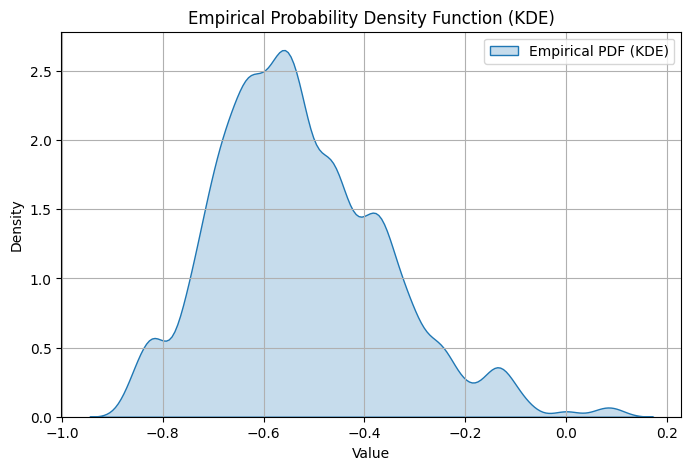

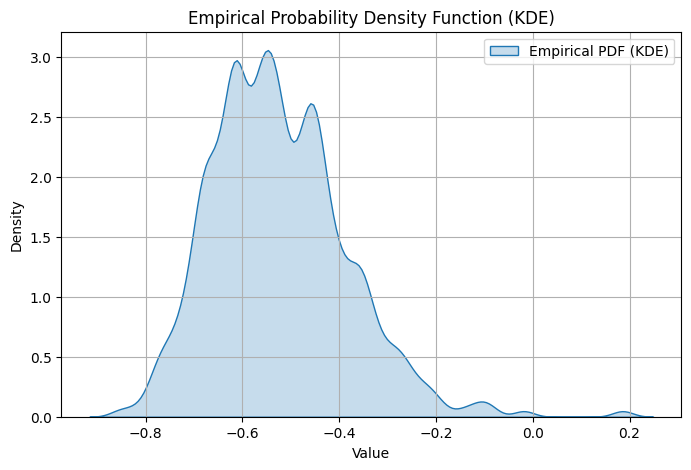

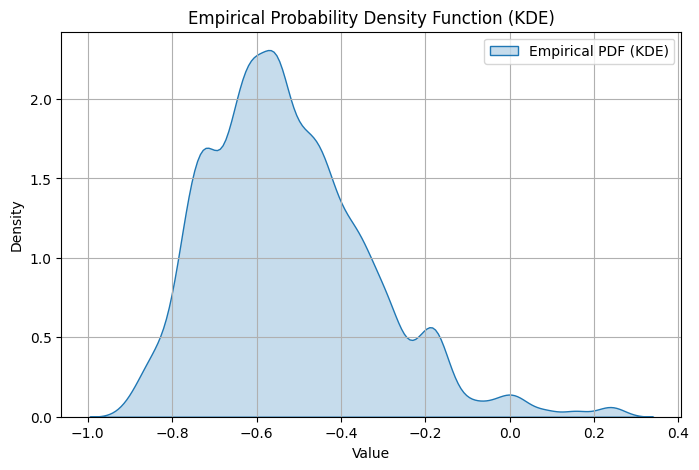

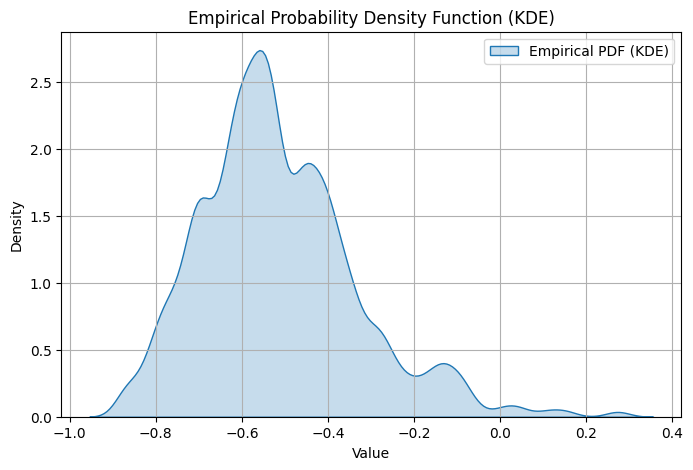

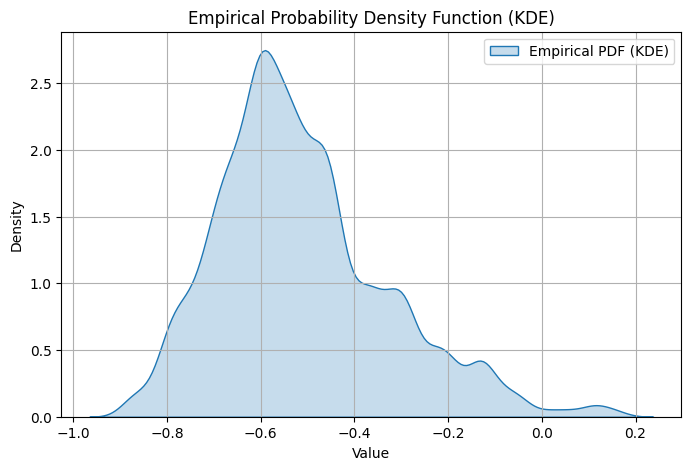

In [64]:
assess_cross_sec_dist(to_13_dict, score = 'lm_polarity')

In [59]:
def convert_to_quarter(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    quarter = (date.month - 1) // 3 + 1
    formatted_string = f'{date.year}.{quarter}'
    return float(formatted_string)

In [60]:
def get_data_for_FE(dict_for_anal):

    total_df = pl.DataFrame()

    for company in dict_for_anal: 
        row_names = dict_for_anal[company].select(pl.col('row_names')).to_series().to_list()
        
        df = dict_for_anal[company].filter(pl.col("row_names") != 'doc_length')
        row_names.remove('doc_length')
        df = df.select(pl.exclude('row_names'))
    
        quarter_strings = [convert_to_quarter(date) for date in df.columns]
        quarter_strings = pl.Series('date', quarter_strings)
    
        df_w_dates = df.transpose().hstack([quarter_strings])
        df_w_company = df_w_dates.with_columns(pl.lit(company).alias('company'))

        column_name_order = ['company', 'date']
        column_name_order.extend(df.transpose().columns)

        prepared_df = df_w_company.select(column_name_order)
        total_df.vstack(prepared_df, in_place=True)

    total_df_pd = total_df.to_pandas()
   
    col_names =  ['company', 'date']
    col_names.extend(row_names)
   
    total_df_pd.columns = col_names
    total_df_pd = total_df_pd.set_index(['company', 'date'])
    
    return total_df_pd 

In [61]:
to_13_df = get_data_for_FE(to_13_dict)
to_23_df = get_data_for_FE(to_23_dict)

In [90]:
def compute_and_plot_quantiles(df: pd.DataFrame, score: str) -> pd.DataFrame:
    """
    Computes 10 quantiles across all companies for each date for the first `n` columns 
    and plots all quantile lines against dates.

    Parameters:
    df (pd.DataFrame): DataFrame with MultiIndex (company, date) and numerical values.
    n (int): Number of columns to consider (default=6).
    
    Returns:
    pd.DataFrame: DataFrame of quantiles indexed by date.
    """
    
    # Compute 10 quantiles (0th to 100th percentile) for each date
    quantiles = np.linspace(0, 1, 10)
    quantile_df = df[score].groupby(level='date').quantile(quantiles)
    
    # Plot all quantile lines
    plt.figure(figsize=(12, 6))
    dates = quantile_df.index.get_level_values('date').unique()

    for q in quantiles:
        plt.plot(dates, quantile_df.xs(q, level=1), label=f"{int(q * 100)}th percentile")

    plt.xlabel("Date")
    plt.ylabel("Quantile Values")
    plt.title(f"Quantiles Over Time for {score}")
    plt.legend()
    plt.grid()
    plt.show()

    return quantile_df

In [78]:
to_23_df.columns

Index(['lm_polarity', 'lm_raw', 'hiv4_polarity', 'hiv4_raw', 'eps_surprise',
       'firm_size', 'day_2_returns', 'day_3_returns', 'day_4_returns',
       'day_5_returns', 'day_6_returns', 'day_7_returns',
       'full_quarter_returns'],
      dtype='object')

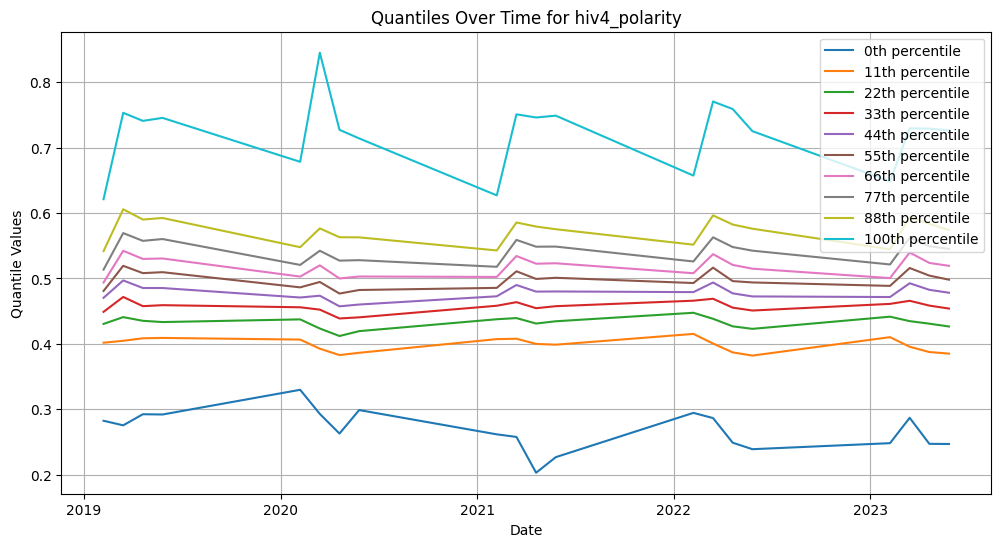

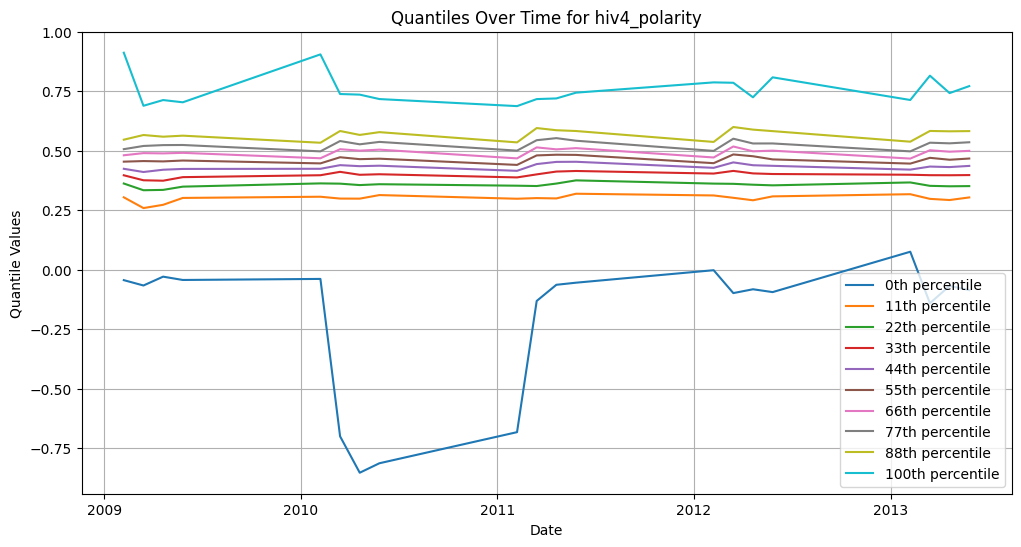

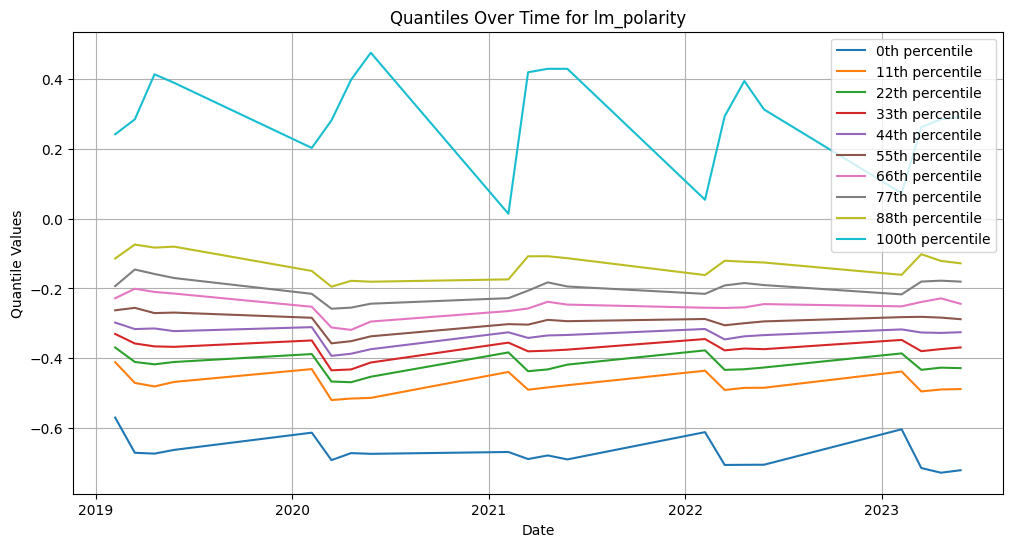

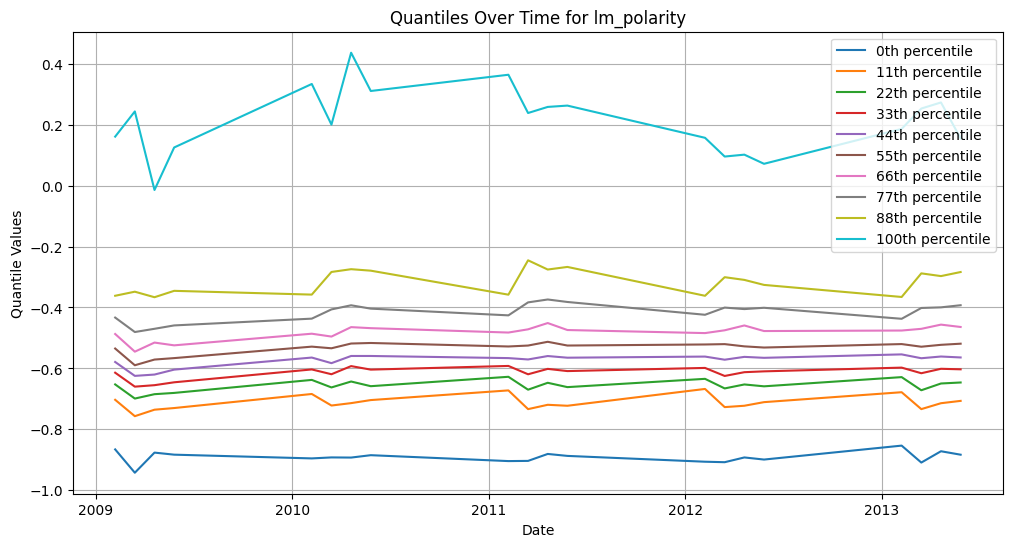

In [91]:
for score in ["hiv4_polarity", "lm_polarity"]:
    for df in [to_23_df, to_13_df]:
        compute_and_plot_quantiles(df, score)